In [1]:
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize 
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import deque
# Import the custom Model class
from Model import Model

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)

plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['VTI','AGG','DBC','VIXY']  # Example tickers for the portfolio
START_DATE = '2019-01-01'
END_DATE = "2024-01-01"  # Replace this with your actual END_DATE if it's variable
end_date_dt = pd.to_datetime(END_DATE)
start_date_6_month_dt = end_date_dt - pd.DateOffset(months=6)
start_date_6_month = start_date_6_month_dt.strftime('%Y-%m-%d')
end_date_6_month = end_date_dt.strftime('%Y-%m-%d')

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")


Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_3880\655916705.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, START_DATE, END_DATE)
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")


[*********************100%%**********************]  4 of 4 completed

Data fetched successfully. Sample data:
Ticker            AGG        DBC         VIXY         VTI
Date                                                     
2019-01-02  91.538506  13.549266  2996.800049  116.516739
2019-01-03  91.916412  13.661166  3137.600098  113.816597
2019-01-04  91.641571  13.847668  2885.600098  117.584030
2019-01-07  91.486946  13.950241  2824.800049  118.769905
2019-01-08  91.418259  14.090117  2765.600098  119.992271
Data covers 1258 trading days with 4 assets.


In [3]:
# Data Preprocessing Step
# Objective: Prepare data by calculating daily returns and normalizing for model input

def preprocess_data(data):
    """
    Prepares data for the LSTM model by calculating returns and normalizing prices.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets

    Returns:
    - normalized_data: DataFrame with prices normalized to start at 1 for each asset
    - returns: DataFrame with daily returns for each asset
    """
    # Calculate daily returns as percentage changes
    returns = data.pct_change().dropna()
    
    # Normalize prices so each series starts at 1
    normalized_data = data / data.iloc[0]
    
    return normalized_data, returns

# Run preprocessing and display sample data
normalized_data, returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC      VIXY       VTI
Date                                              
2019-01-02  1.000000  1.000000  1.000000  1.000000
2019-01-03  1.004128  1.008259  1.046983  0.976826
2019-01-04  1.001126  1.022023  0.962894  1.009160
2019-01-07  0.999437  1.029594  0.942605  1.019338
2019-01-08  0.998686  1.039917  0.922851  1.029829

Sample daily returns:
Ticker           AGG       DBC      VIXY       VTI
Date                                              
2019-01-03  0.004128  0.008259  0.046983 -0.023174
2019-01-04 -0.002990  0.013652 -0.080316  0.033101
2019-01-07 -0.001687  0.007407 -0.021070  0.010085
2019-01-08 -0.000751  0.010027 -0.020957  0.010292
2019-01-09  0.000845  0.019854 -0.023141  0.004713


In [4]:
class Portfolio:
    def __init__(self, initial_cash: float, assets: pd.DataFrame):
        """
        Initializes the Portfolio object.

        Parameters:
        - initial_cash: The starting value of the portfolio in cash.
        - assets: DataFrame of asset prices (historical data).
        """
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.assets = assets  # Historical price data for the assets
        self.weights = np.zeros(len(assets.columns))  # Initialize weights as zero
        self.portfolio_history = []  # To track portfolio value over time
        self.rebalancing_dates = []  # To store rebalancing dates

    def rebalance(self, new_weights: np.array, target_volatility = None):
        """
        Rebalances the portfolio according to new weights.

        Parameters:
        - new_weights: Numpy array of asset allocations.
        """
        if len(new_weights) != len(self.assets.columns):
            raise ValueError("Number of weights must match the number of assets.")
        self.weights = new_weights
        if target_volatility is not None:
            self.apply_volatility_scaling(target_volatility=target_volatility,rolling_window = 50)

    def calculate_initial_shares(self, initial_cash, initial_prices):
        """
        Calculates the number of shares for each asset at the start of the testing period based on
        initial cash and allocation weights.

        Parameters:
        - initial_cash: The starting cash value of the portfolio.

        Returns:
        - shares: Dictionary with tickers as keys and the initial number of shares as values.
        """
        # Calculate the dollar amount allocated to each asset
        dollar_allocation = initial_cash * self.weights

        # Calculate the number of shares for each asset
        shares = (dollar_allocation // initial_prices).astype(int)  # Floor division to get whole shares

        # Return as a dictionary for easy readability
        return dict(zip(self.assets.columns, shares))
    
    def calculate_daily_returns(self):
        """
        Applies the current weights to asset returns and updates portfolio value over time.
        """
        # Calculate daily returns for each asset
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate portfolio returns by applying weights
        portfolio_returns = np.dot(daily_returns, self.weights)

        # Track the portfolio's value over time by compounding the returns
        for daily_ret in portfolio_returns:
            self.current_value *= (1 + daily_ret)
            self.portfolio_history.append(self.current_value)

    def update_portfolio_value(self, date):
        """
        Updates the portfolio value for a single date.
        """
        # Get the index of the date
        date_index = self.assets.index.get_loc(date)
        if date_index == 0:
            # First day, no previous day to compute return
            self.portfolio_history.append(self.current_value)
            return
        # Get the asset returns for that day
        previous_date = self.assets.index[date_index - 1]
        daily_return = self.assets.loc[date] / self.assets.loc[previous_date] - 1
        # Calculate portfolio return
        portfolio_return = np.dot(daily_return.values, self.weights)
        # Update portfolio value
        self.current_value *= (1 + portfolio_return)
        # Append to history
        self.portfolio_history.append(self.current_value)


    def track_portfolio_performance(self):
        """
        Tracks and prints the portfolio performance over time.
        """
        for date, value in zip(self.assets.index[1:], self.portfolio_history):
            print(f"Date: {date}, Portfolio Value: {value}")
    
    def reset(self):
        self.current_cash = self.initial_cash
        self.assets = self.initial_assets.copy()
        self.weights = np.zeros(len(self.assets.columns))  # Reset to no investments
        self.portfolio_history = []
        self.rebalancing_dates = []
        return self.assets.iloc[0].values

    def get_portfolio_value(self):
        """
        Returns the current value of the portfolio.
        """
        return self.current_value
    
    def plot_portfolio_value(self):
        """
        Plots the portfolio value over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.assets.index[1:], self.portfolio_history, label="Portfolio Value")
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.show()

    def apply_volatility_scaling(self, target_volatility=0.1, rolling_window=50):
        """
        Scales portfolio allocations based on the ratio of target volatility to current asset volatilities.
        
        Parameters:
        - target_volatility: The target annualized volatility for the portfolio (e.g., 0.1 for 10%).
        - rolling_window: The window size (in days) for calculating each asset's rolling volatility.
        
        Modifies the portfolio's weights to achieve the target volatility for each asset.
        """
        # Calculate daily returns of the portfolio assets
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate rolling volatility (annualized) for each asset over the rolling window
        asset_volatilities = daily_returns.rolling(window=rolling_window).std().iloc[-1] * np.sqrt(252)

        # Compute scaling factor for each asset to achieve the target volatility
        scaling_factors = target_volatility / asset_volatilities

        # Scale weights by the scaling factors
        self.weights = self.weights * scaling_factors

        # Normalize weights to ensure they sum to 1
        self.weights = self.weights / np.sum(self.weights)

        # Debugging: Print intermediate values to verify calculations
        print(f"Asset Volatilities: {asset_volatilities}")
        print(f"Scaling Factors: {scaling_factors}")
        print(f"Scaled and Normalized Weights: {self.weights}")



In [5]:
def train_and_rebalance_portfolio(portfolio: Portfolio, model: Model):
    """
    Trains the LSTM model once over the full dataset and returns a single set of allocation weights.

    Parameters:
    - portfolio: An instance of the Portfolio class.
    - model: An instance of the Model class for training.
    
    Returns:
    - allocations: Final optimized weights for each asset in the portfolio.
    """
    # Use the entire dataset for training
    train_data = portfolio.assets

    # Preprocess the training data
    normalized_data, _ = preprocess_data(train_data)

    # Get allocations from the model
    allocations = model.get_allocations(normalized_data)

    # Rebalance the portfolio with the optimized weights (if needed for tracking)
    portfolio.rebalance(allocations)

    # Return the final allocation weights
    return allocations


In [6]:
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing Sharpe Ratio, Sortino Ratio, and Max Drawdown.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns)
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values) - portfolio_values
    max_drawdown = np.max(cumulative_returns / np.maximum.accumulate(portfolio_values))
    
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }

In [7]:
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed
c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: -0.0137
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - loss: -0.0202
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: -0.0262
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: -0.0314
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: -0.0357
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: -0.0390
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: -0.0417
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: -0.0438
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: -0.0455
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: -0.0469
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: -0.0481
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: -0.0489
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: -0.0496
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: -0.0500
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 

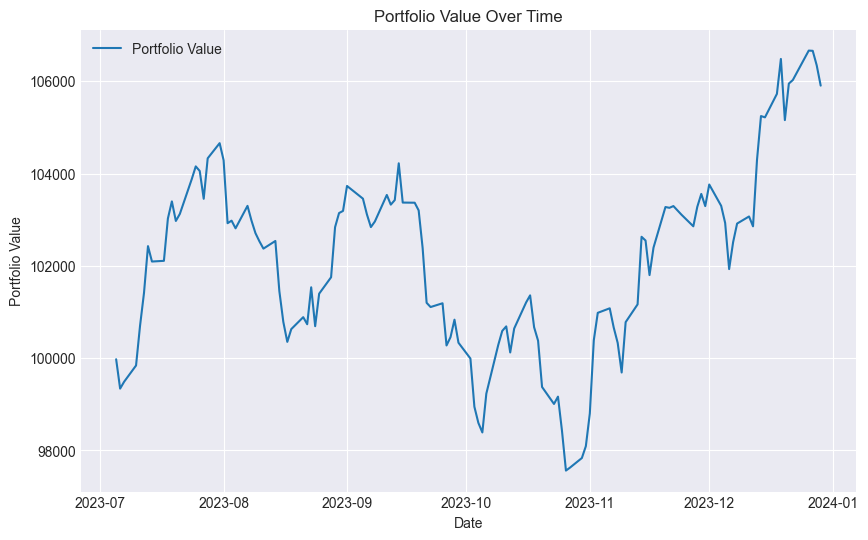

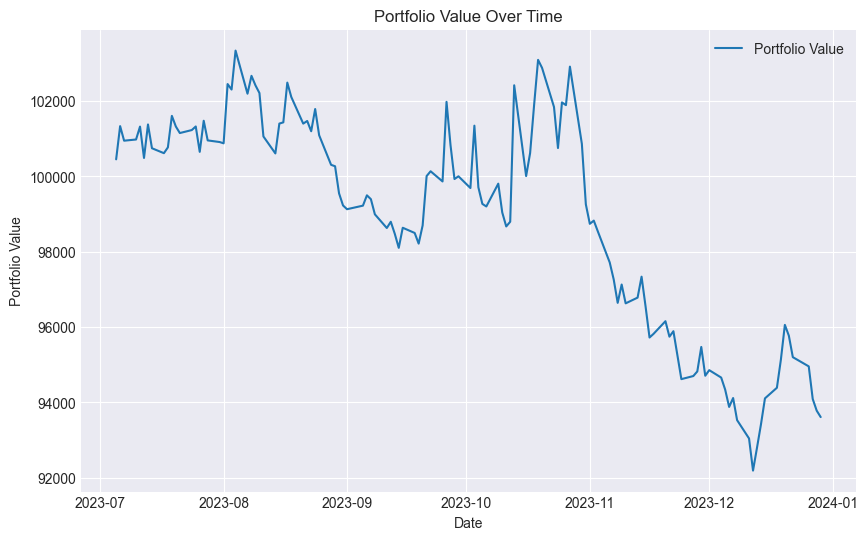

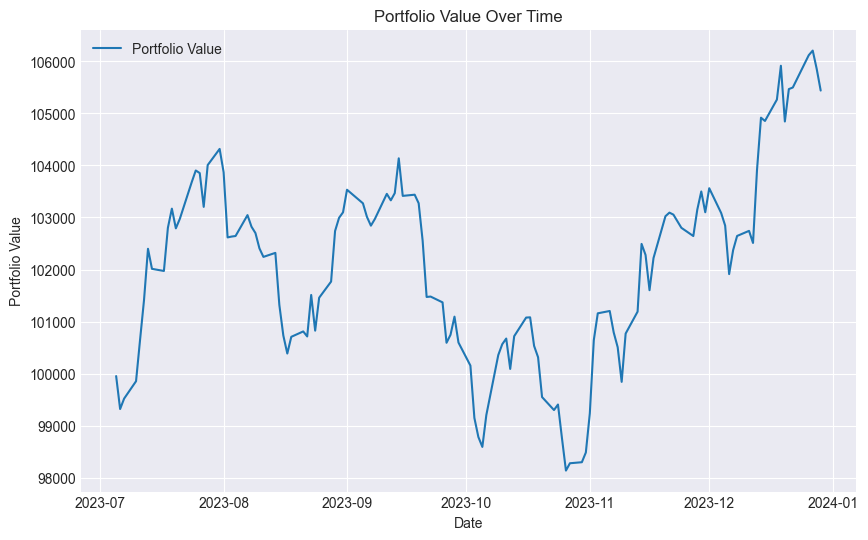


LSTM Portfolio Metrics:
Weights:[0.05029338 0.29331407 0.00719214 0.6492004 ], Shares:{'AGG': 54, 'DBC': 1355, 'VIXY': 7, 'VTI': 299}
{'Sharpe Ratio': 1.2906849264100952, 'Sortino Ratio': 2.290604624087295, 'Max Drawdown': 0.06779070865306966}

Equal-Weighted Portfolio Metrics:
Weights:[0.25 0.25 0.25 0.25], Shares:{'AGG': 268, 'DBC': 1155, 'VIXY': 252, 'VTI': 115}
{'Sharpe Ratio': -1.0649257572308757, 'Sortino Ratio': -1.889408616698441, 'Max Drawdown': 0.10790483224715819}

Mean-Variance Optimized Portfolio Metrics:
Weights:[2.02594653e-01 3.08964022e-01 2.49366500e-18 4.88441325e-01], Shares:{'AGG': 217, 'DBC': 1427, 'VIXY': 0, 'VTI': 225}
{'Sharpe Ratio': 1.304512544635209, 'Sortino Ratio': 2.4380019188747712, 'Max Drawdown': 0.05927526370567057}


In [8]:
# Step 1: Data Preparation for Training and Testing
train_data = get_data(TICKERS, START_DATE, END_DATE)
normalized_train_data, training_returns = preprocess_data(train_data)

testing_data = get_data(TICKERS, start_date_6_month, end_date_6_month)
normalized_testing_data, testing_returns = preprocess_data(testing_data)

# Step 2: Train and Rebalance Portfolio in Training Phase (rebalancing every two years)
training_portfolio = Portfolio(100000, normalized_train_data)
model = Model()
initial_prices = testing_data.loc[testing_data.index[0]]  # First row of the actual price data
# Rebalance every 2 years (252 trading days * 2)
final_allocations = train_and_rebalance_portfolio(training_portfolio, model=model)

# Step 3: Initialize Testing Portfolio with Final LSTM Weights
testing_portfolio = Portfolio(100000, normalized_testing_data)
testing_portfolio.rebalance(final_allocations)
LSTM_shares = testing_portfolio.calculate_initial_shares(100000,initial_prices)  # Calculate initial shares based on final allocations
testing_portfolio.calculate_daily_returns()     # Track performance in testing period
testing_portfolio.plot_portfolio_value()        # Visualize portfolio value over time
# Step 4: Calculate Performance Metrics for LSTM Portfolio
metrics = calculate_metrics(testing_portfolio.portfolio_history)

# Step 5: Baseline Strategies Setup and Evaluation
# Equal-Weighted and Mean-Variance Optimized Portfolios
equal_weights = equal_weighted_strategy(training_returns)
mv_optimized_weights = mean_variance_optimized_strategy(training_returns)

equal_weight_portfolio = Portfolio(100000, normalized_testing_data)
mv_optimized_portfolio = Portfolio(100000, normalized_testing_data)

equal_weight_portfolio.rebalance(equal_weights)
mv_optimized_portfolio.rebalance(mv_optimized_weights)

equal_weight_portfolio.calculate_daily_returns()
mv_optimized_portfolio.calculate_daily_returns()
ew_shares = equal_weight_portfolio.calculate_initial_shares(100000,initial_prices)
mv_shares = mv_optimized_portfolio.calculate_initial_shares(100000,initial_prices)
equal_weight_portfolio.plot_portfolio_value()
mv_optimized_portfolio.plot_portfolio_value()
# Step 6: Calculate Performance Metrics for Baseline Portfolios
equal_weight_metrics = calculate_metrics(equal_weight_portfolio.portfolio_history)
mv_optimized_metrics = calculate_metrics(mv_optimized_portfolio.portfolio_history)

# Step 7: Calculate Expected Annual Return with Actual Prices
start_date_6_month = '2023-07-01'
end_date_6_month = '2024-01-01'
print("\nLSTM Portfolio Metrics:")
print(f"Weights:{final_allocations}, Shares:{LSTM_shares}")
print(metrics)

print("\nEqual-Weighted Portfolio Metrics:")
print(f"Weights:{equal_weights}, Shares:{ew_shares}")
print(equal_weight_metrics)

print("\nMean-Variance Optimized Portfolio Metrics:")
print(f"Weights:{mv_optimized_weights}, Shares:{mv_shares}")
print(mv_optimized_metrics)


[*********************100%%**********************]  4 of 4 completed
c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0183
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.0058
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: -0.0069
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: -0.0189
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: -0.0295
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: -0.0386
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: -0.0461
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: -0.0523
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: -0.0574
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: -0.0617
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: -0.0653
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: -0.0683
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: -0.0709
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: -0.0730
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: -0

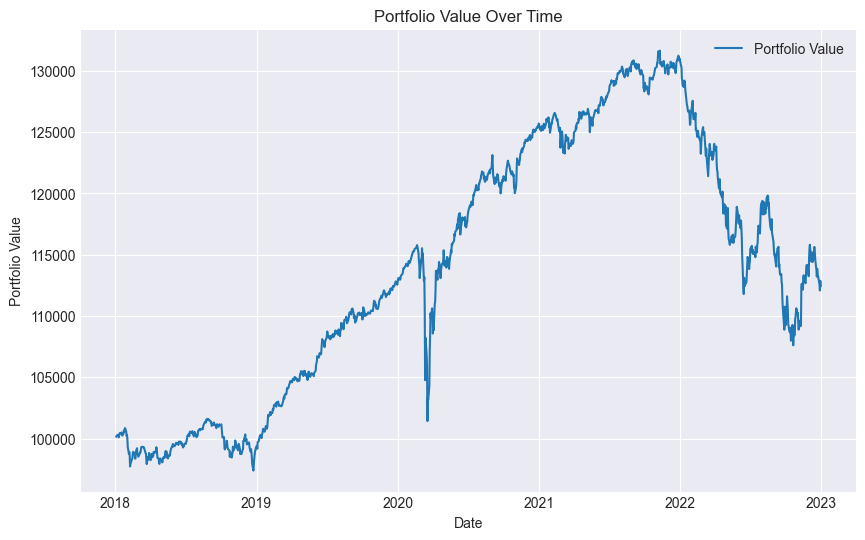

Test Metrics: {'Sharpe Ratio': 0.3584128386536296, 'Sortino Ratio': 0.3976378463305289, 'Max Drawdown': 0.18260600045521308}
Final Allocations: [0.76640123 0.0008474  0.00105966 0.23169178]


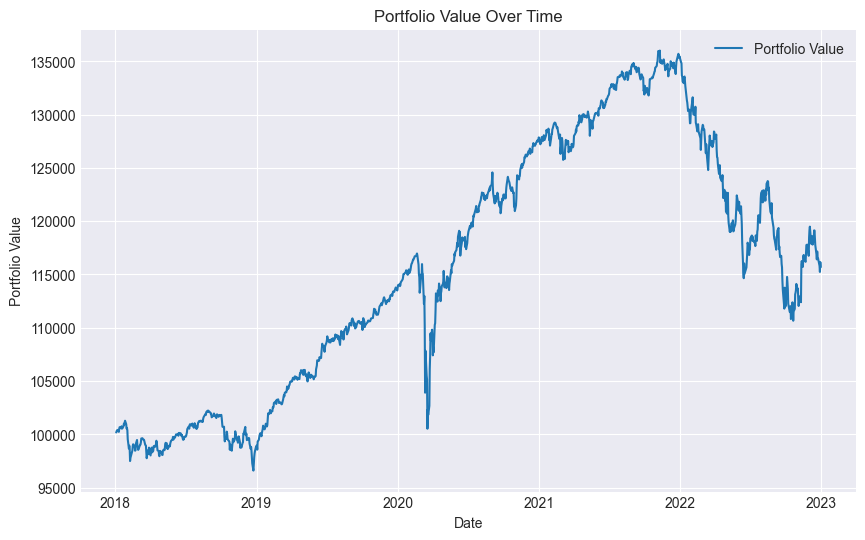

Mean-Variance Optimized Metrics: {'Sharpe Ratio': 0.395578376307422, 'Sortino Ratio': 0.4463791654639544, 'Max Drawdown': 0.18634779784927788}
Mean-Variance Optimized Allocations: [7.06420288e-01 0.00000000e+00 5.63785130e-17 2.93579712e-01]


In [9]:
# Step 1: Fetch data for a 10-year period
tickers = ['VTI', 'AGG', 'DBC', 'VIXY']
start_date = '2013-01-01'  # Start date for 10 years of data
end_date = '2023-01-01'    # End date for testing
data = get_data(tickers, start_date, end_date)

# Step 2: Define train-test split (e.g., 50% for training, 50% for testing)
split_ratio = 0.5
split_index = int(len(data) * split_ratio)

# Step 3: Split and preprocess data
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

normalized_train, _ = preprocess_data(train_data)
normalized_test, _ = preprocess_data(test_data)

# Step 4: Train model on training data
model = Model()
training_portfolio = Portfolio(initial_cash=100000, assets=normalized_train)
training_returns = training_portfolio.assets.pct_change().dropna()
final_allocations = train_and_rebalance_portfolio(training_portfolio, model=model)

# Step 5: Test on the holdout set using final allocations
testing_portfolio = Portfolio(initial_cash=100000, assets=normalized_test)
testing_portfolio.rebalance(final_allocations)
testing_portfolio.calculate_daily_returns()
testing_portfolio.plot_portfolio_value()
# Calculate test performance metrics
metrics = calculate_metrics(testing_portfolio.portfolio_history)
print(f"Test Metrics: {metrics}")
print(f"Final Allocations: {final_allocations}")
# Step 6: Use mean-variance optimization for comparison
mv_optimized_weights = mean_variance_optimized_strategy(training_returns)
mv_optimized_portfolio = Portfolio(initial_cash=100000, assets=normalized_test)
mv_optimized_portfolio.rebalance(mv_optimized_weights)
mv_optimized_portfolio.calculate_daily_returns()
mv_optimized_portfolio.plot_portfolio_value()
mv_optimized_metrics = calculate_metrics(mv_optimized_portfolio.portfolio_history)
print(f"Mean-Variance Optimized Metrics: {mv_optimized_metrics}")
print(f"Mean-Variance Optimized Allocations: {mv_optimized_weights}")


In [ ]:
def generalized_rolling_validation(data, allocation_strategy, train_years=2, test_months=12, initial_cash=100000):
    """
    Performs rolling validation with a specified allocation strategy, aligned with the paper's periodic retraining and testing.
    
    Parameters:
    - data: DataFrame of historical prices.
    - allocation_strategy: Function that computes portfolio allocations based on training data.
    - train_years: Number of years for the training period in each roll.
    - test_months: Number of months for the testing period in each roll.
    - initial_cash: Initial investment amount.

    Returns:
    - results: List of dictionaries with performance metrics for each roll.
    """
    results = []
    start_date = data.index[0]
    
    while True:
        # Define training and testing windows
        train_end = start_date + pd.DateOffset(years=train_years)
        test_start = train_end + timedelta(days=1)
        test_end = test_start + pd.DateOffset(months=test_months)
        
        # Stop if testing period exceeds available data
        if test_end > data.index[-1]:
            break
        
        # Split data into train and test sets for this roll
        train_data = data.loc[start_date:train_end]
        test_data = data.loc[test_start:test_end]
        
        # Preprocess the training and testing data
        normalized_train, train_returns = preprocess_data(train_data)
        normalized_test, _ = preprocess_data(test_data)
        
        # Train the model and get allocations
        if allocation_strategy == train_and_rebalance_portfolio:
            model = Model()
            training_portfolio = Portfolio(initial_cash=initial_cash, assets=normalized_train)
            final_allocations = allocation_strategy(training_portfolio, model=model)
        else:
            # Non-LSTM strategy (e.g., equal-weighted or mean-variance)
            final_allocations = allocation_strategy(train_returns if allocation_strategy == mean_variance_optimized_strategy else normalized_train)
        
        # Initialize the testing portfolio with final allocations
        testing_portfolio = Portfolio(initial_cash=initial_cash, assets=normalized_test)
        testing_portfolio.portfolio_history = []  # Clear history before starting new testing period
        testing_portfolio.rebalance(final_allocations, target_volatility=0.1)  # Initial rebalancing with volatility scaling
        last_rebalance_date = normalized_test.index[0]

        if allocation_strategy == train_and_rebalance_portfolio:
            # Daily rebalancing during the testing period
            for date in normalized_test.index[1:]:  # Skip the first row since we initialized
                # Adjust weights based on volatility scaling monthly
                testing_portfolio.rebalance(testing_portfolio.weights, target_volatility=0.1)
                last_rebalance_date = date  # Update the last rebalance date
                # Update portfolio value for the date
                testing_portfolio.update_portfolio_value(date)
        else:
            testing_portfolio.calculate_daily_returns()  # Track performance in testing period


        # Calculate performance metrics for this roll
        metrics = calculate_metrics(testing_portfolio.portfolio_history)
        
        # Store results for this roll
        results.append({
            'train_period': (start_date, train_end),
            'test_period': (test_start, test_end),
            'metrics': metrics
        })
        
        # Plot the portfolio value over time for this roll
        testing_portfolio.plot_portfolio_value()
        
        # Move the start date forward for the next roll
        start_date = start_date + pd.DateOffset(months=test_months)
    
    return results


[*********************100%%**********************]  4 of 4 completed

Epoch 1/100



c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0420
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0395
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0359
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0310
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0245
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0166
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0079
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: -6.2678e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: -0.0082
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: -0.0145
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: -0.0195
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: -0.0234
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: -0.0266
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: -0.0291
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: -0.0312
Epoch 1

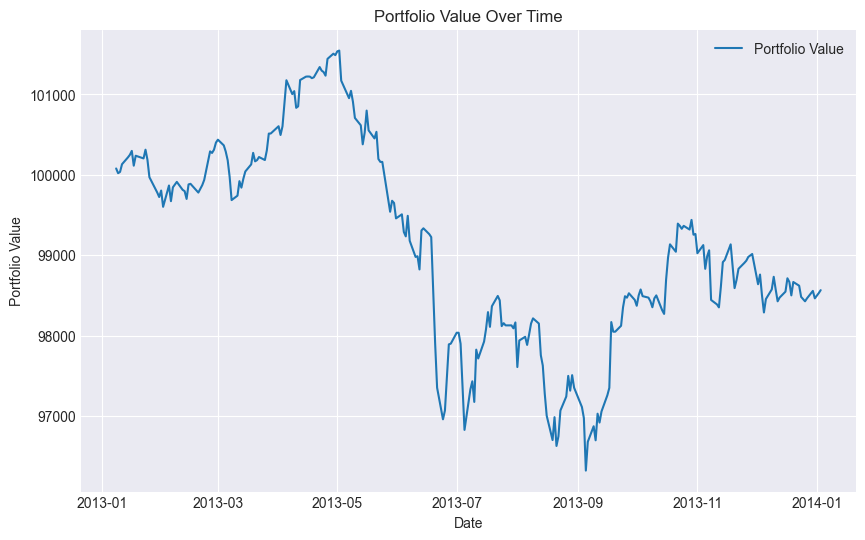

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0190
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0019
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: -0.0149
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: -0.0307
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: -0.0452
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: -0.0581
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: -0.0693
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: -0.0787
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: -0.0865
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: -0.0926
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: -0.0973
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: -0.1008
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: -0.1034
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: -0.1053
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: -0

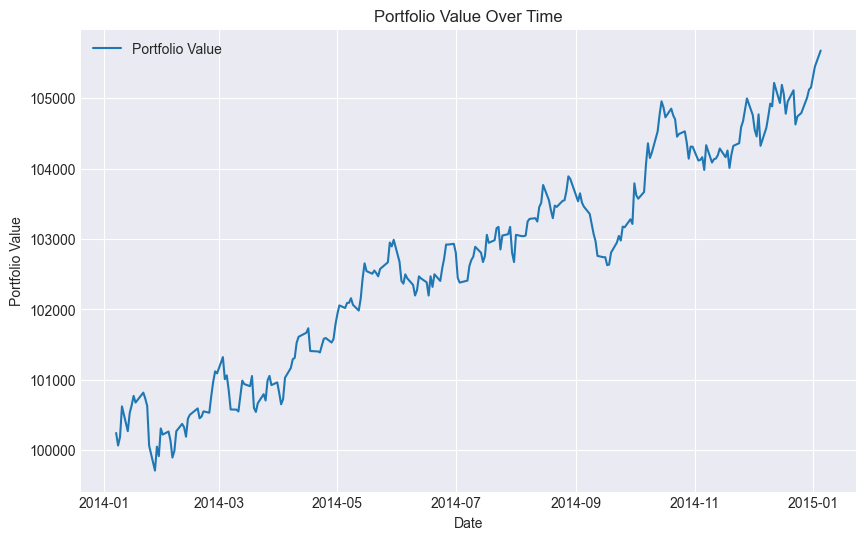

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0519
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0300
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0056
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: -0.0191
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: -0.0416
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: -0.0604
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: -0.0750
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: -0.0858
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: -0.0935
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: -0.0989
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: -0.1026
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: -0.1051
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: -0.1069
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: -0.1081
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: -0.

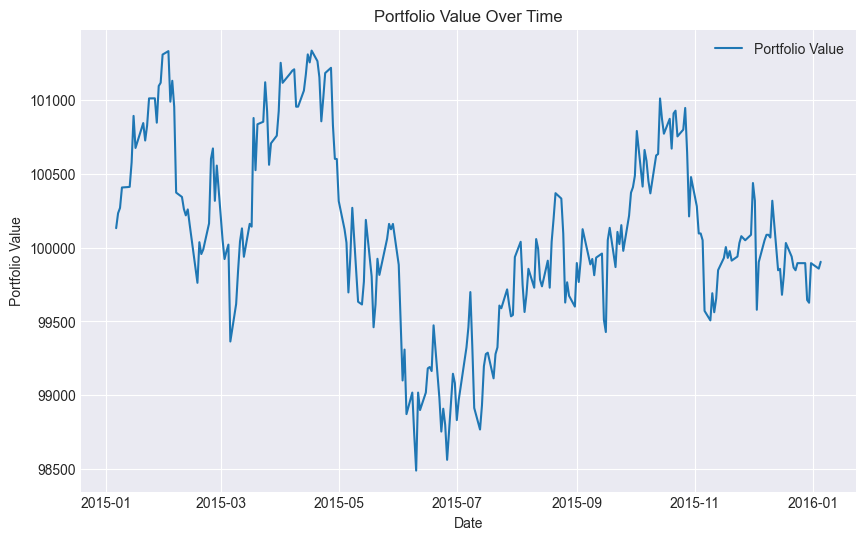

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0518
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0476
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0439
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0407
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0378
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0352
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0328
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0306
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0285
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0265
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0246
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0227
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0210
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0193
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0179
Epoch 1

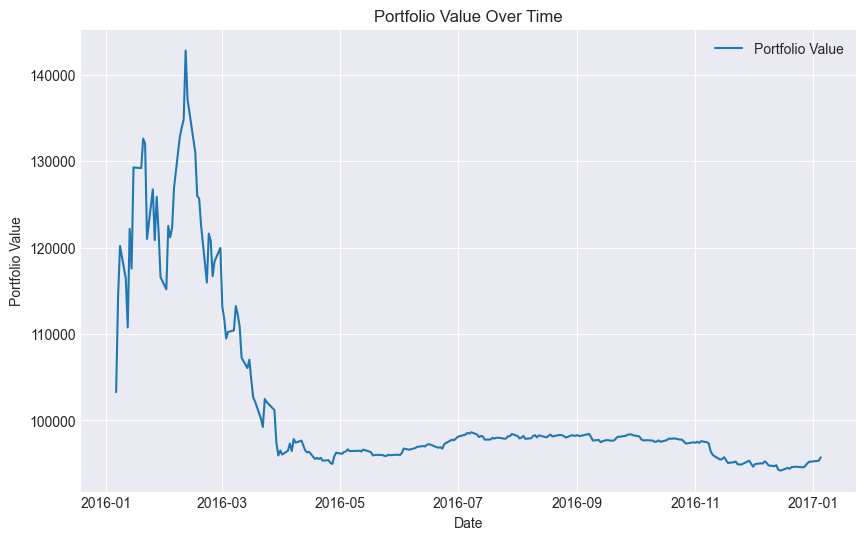

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0694
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0673
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0612
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0484
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0294
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0093
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -0.0068
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: -0.0180
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: -0.0253
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: -0.0302
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: -0.0334
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: -0.0356
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: -0.0371
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: -0.0382
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: -0.038

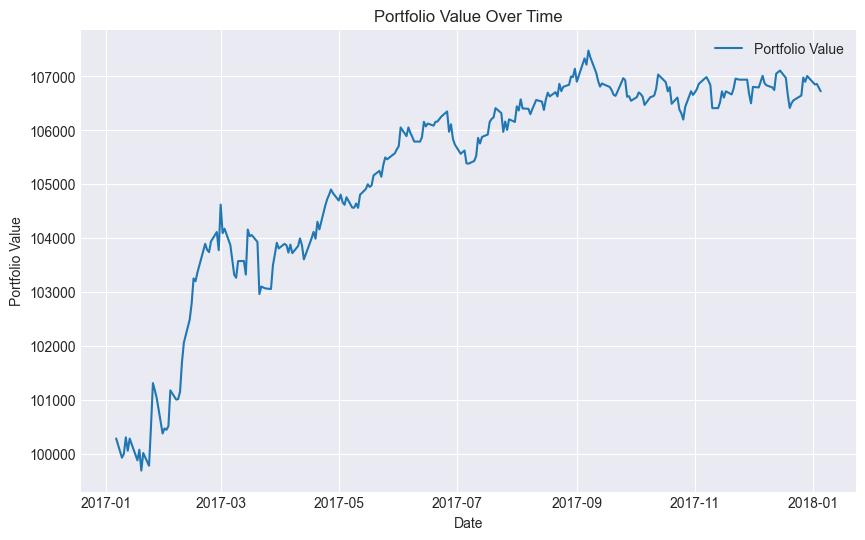

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0347
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0221
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0071
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: -0.0110
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: -0.0321
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: -0.0549
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: -0.0766
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: -0.0942
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: -0.1064
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: -0.1137
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -0.1177
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: -0.1197
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -0.1206
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: -0.1211
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -0.

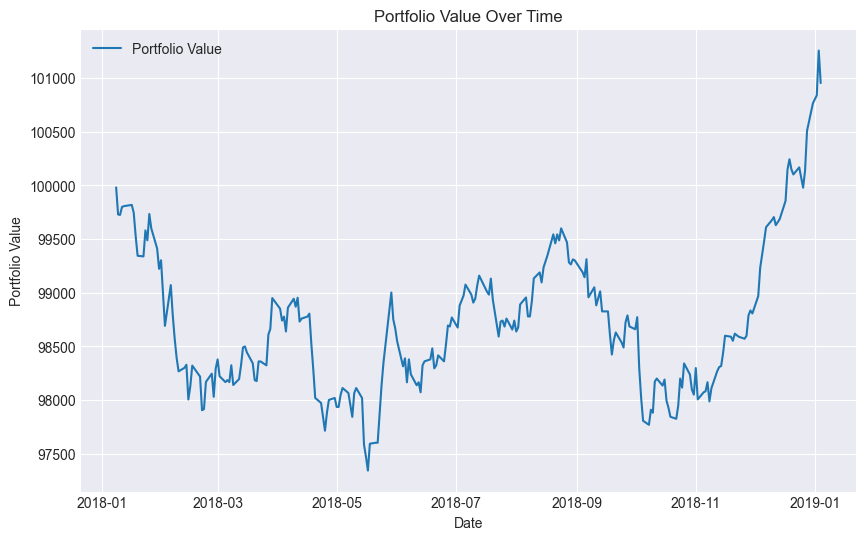

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0496
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0471
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0431
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0376
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0308
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0232
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0156
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0083
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0017
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: -0.0043
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: -0.0096
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: -0.0144
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: -0.0186
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: -0.0224
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: -0.0257
E

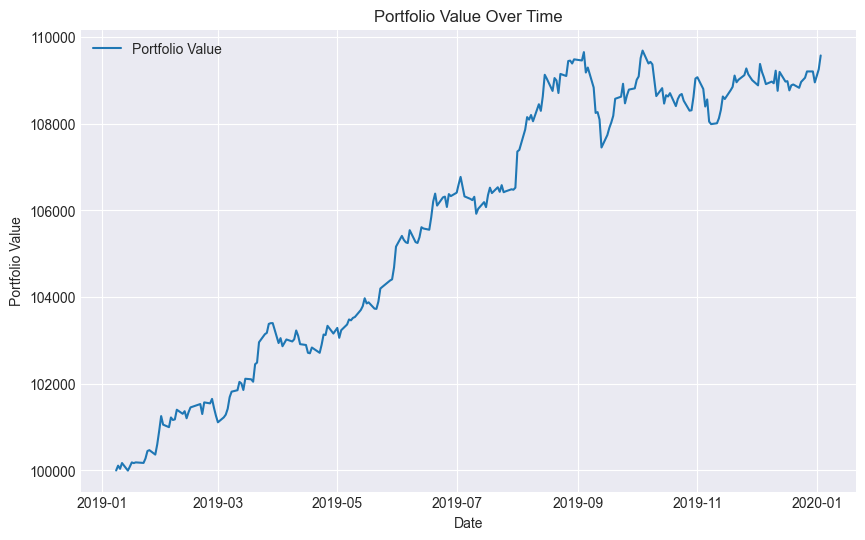

LSTM Results: [{'train_period': (Timestamp('2011-01-04 00:00:00'), Timestamp('2013-01-04 00:00:00')), 'test_period': (Timestamp('2013-01-05 00:00:00'), Timestamp('2014-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': -0.41786842970283505, 'Sortino Ratio': -0.5320842304366379, 'Max Drawdown': 0.05141179952173909}}, {'train_period': (Timestamp('2012-01-04 00:00:00'), Timestamp('2014-01-04 00:00:00')), 'test_period': (Timestamp('2014-01-05 00:00:00'), Timestamp('2015-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': 1.915209651064257, 'Sortino Ratio': 3.0012578227731646, 'Max Drawdown': 0.01215576094499619}}, {'train_period': (Timestamp('2013-01-04 00:00:00'), Timestamp('2015-01-04 00:00:00')), 'test_period': (Timestamp('2015-01-05 00:00:00'), Timestamp('2016-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': -0.043544500735481426, 'Sortino Ratio': -0.06329857574723653, 'Max Drawdown': 0.028068452714661317}}, {'train_period': (Timestamp('2014-01-04 00:00:00'), Timestamp('2016-01-04 00:00:00')), 't

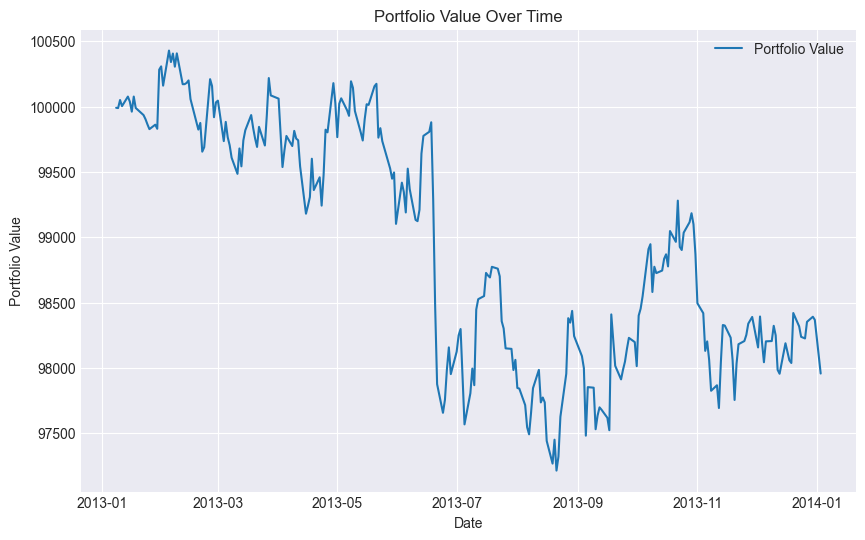

Asset Volatilities: Ticker
AGG     0.031522
DBC     0.180390
VIXY    0.598318
VTI     0.123899
Name: 2015-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     3.172434
DBC     0.554356
VIXY    0.167135
VTI     0.807110
Name: 2015-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.674837
DBC     0.117922
VIXY    0.035553
VTI     0.171688
Name: 2015-01-05 00:00:00, dtype: float64


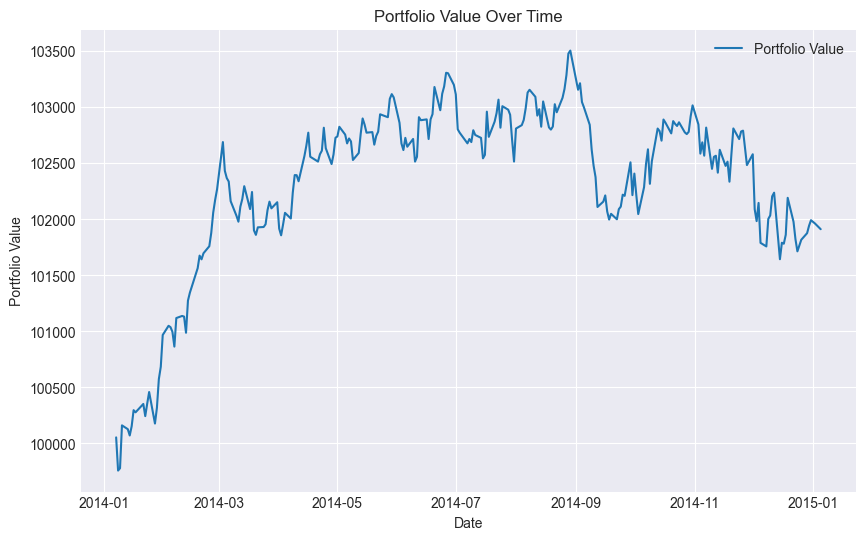

Asset Volatilities: Ticker
AGG     0.033328
DBC     0.162906
VIXY    0.791034
VTI     0.151150
Name: 2016-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     3.000504
DBC     0.613851
VIXY    0.126417
VTI     0.661594
Name: 2016-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.681566
DBC     0.139437
VIXY    0.028716
VTI     0.150282
Name: 2016-01-05 00:00:00, dtype: float64


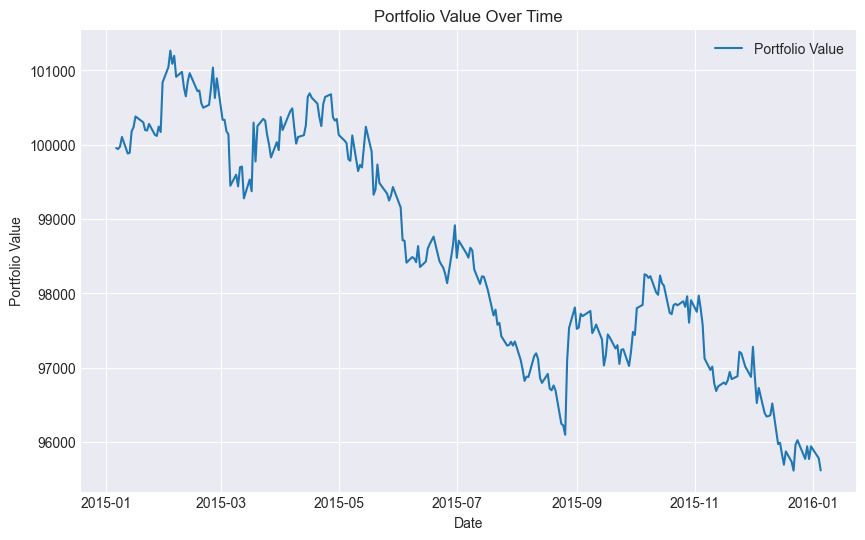

Asset Volatilities: Ticker
AGG     0.041372
DBC     0.162648
VIXY    0.501642
VTI     0.092567
Name: 2017-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     2.417081
DBC     0.614824
VIXY    0.199345
VTI     1.080303
Name: 2017-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.560606
DBC     0.142599
VIXY    0.046235
VTI     0.250560
Name: 2017-01-05 00:00:00, dtype: float64


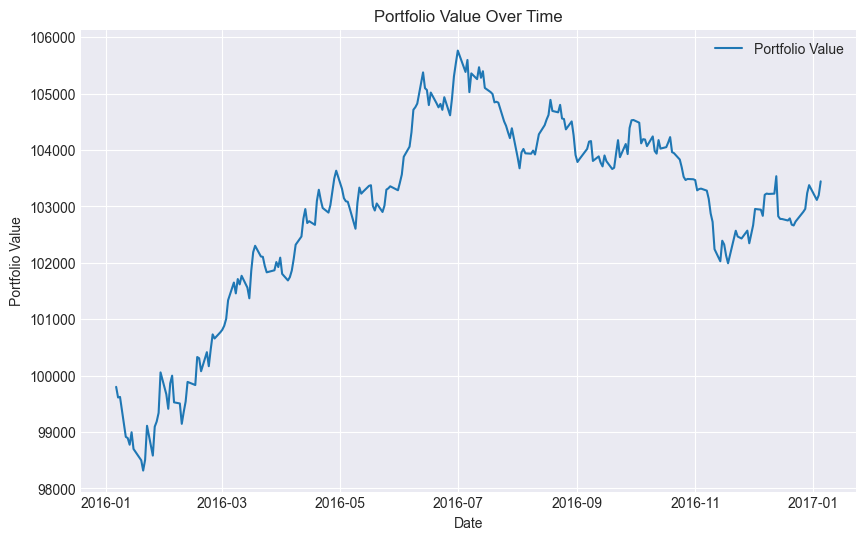

Asset Volatilities: Ticker
AGG     0.023325
DBC     0.108507
VIXY    0.308044
VTI     0.064037
Name: 2018-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     4.287187
DBC     0.921599
VIXY    0.324629
VTI     1.561609
Name: 2018-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.604253
DBC     0.129894
VIXY    0.045755
VTI     0.220099
Name: 2018-01-05 00:00:00, dtype: float64


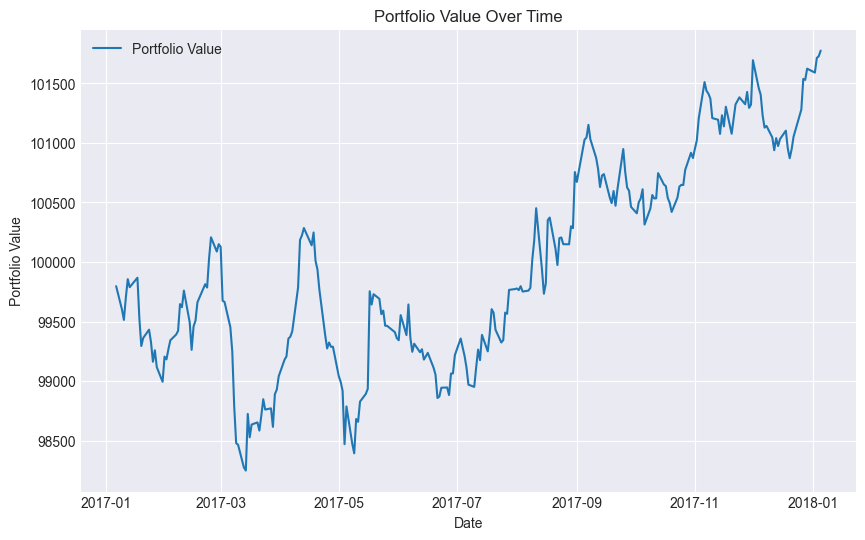

Asset Volatilities: Ticker
AGG     0.024476
DBC     0.185355
VIXY    0.714141
VTI     0.258217
Name: 2019-01-04 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     4.085575
DBC     0.539506
VIXY    0.140028
VTI     0.387271
Name: 2019-01-04 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.792949
DBC     0.104710
VIXY    0.027177
VTI     0.075163
Name: 2019-01-04 00:00:00, dtype: float64


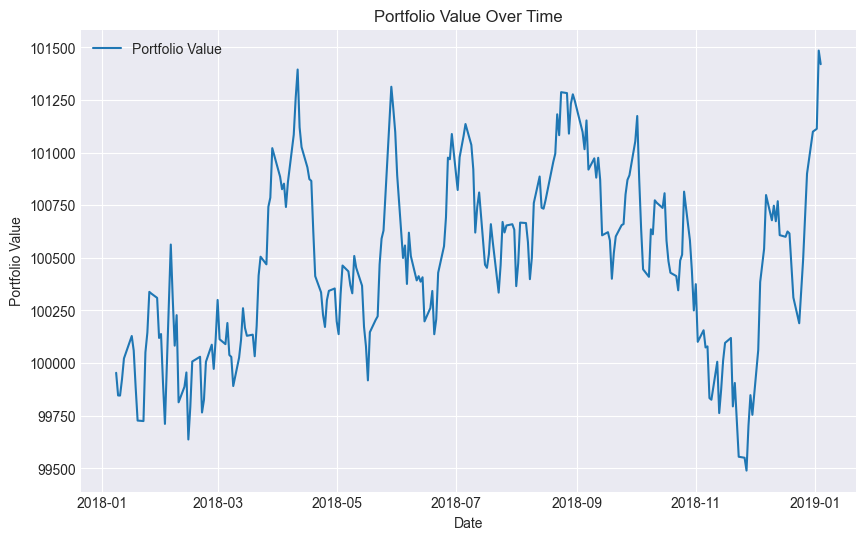

Asset Volatilities: Ticker
AGG     0.032830
DBC     0.112749
VIXY    0.434699
VTI     0.068737
Name: 2020-01-03 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     3.045958
DBC     0.886923
VIXY    0.230044
VTI     1.454810
Name: 2020-01-03 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.542204
DBC     0.157879
VIXY    0.040950
VTI     0.258967
Name: 2020-01-03 00:00:00, dtype: float64


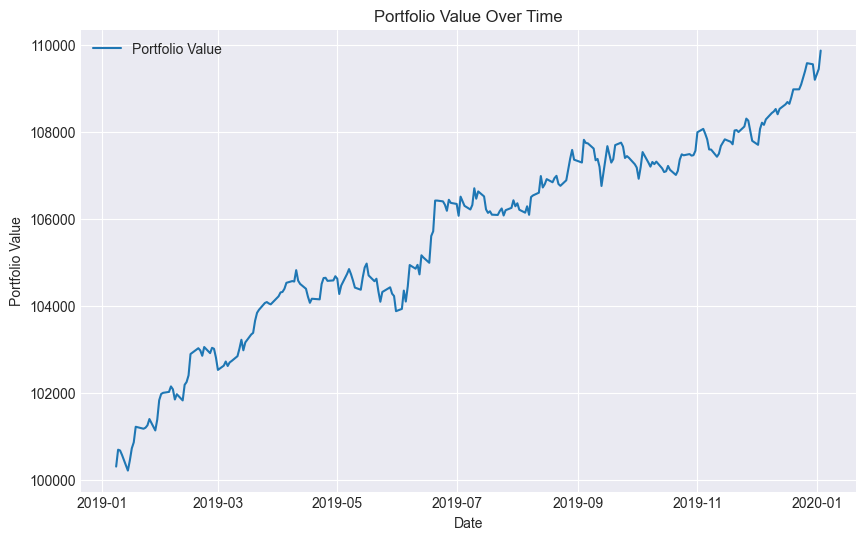

Equal-Weighted Results: [{'train_period': (Timestamp('2011-01-04 00:00:00'), Timestamp('2013-01-04 00:00:00')), 'test_period': (Timestamp('2013-01-05 00:00:00'), Timestamp('2014-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': -0.5970454703598921, 'Sortino Ratio': -0.8959633220671122, 'Max Drawdown': 0.03201053126892587}}, {'train_period': (Timestamp('2012-01-04 00:00:00'), Timestamp('2014-01-04 00:00:00')), 'test_period': (Timestamp('2014-01-05 00:00:00'), Timestamp('2015-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': 0.7584993294456673, 'Sortino Ratio': 1.1161756941536307, 'Max Drawdown': 0.01798270439328271}}, {'train_period': (Timestamp('2013-01-04 00:00:00'), Timestamp('2015-01-04 00:00:00')), 'test_period': (Timestamp('2015-01-05 00:00:00'), Timestamp('2016-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': -1.1860570776759063, 'Sortino Ratio': -1.9430716296821198, 'Max Drawdown': 0.05582275491621314}}, {'train_period': (Timestamp('2014-01-04 00:00:00'), Timestamp('2016-01-04 00:00:00'

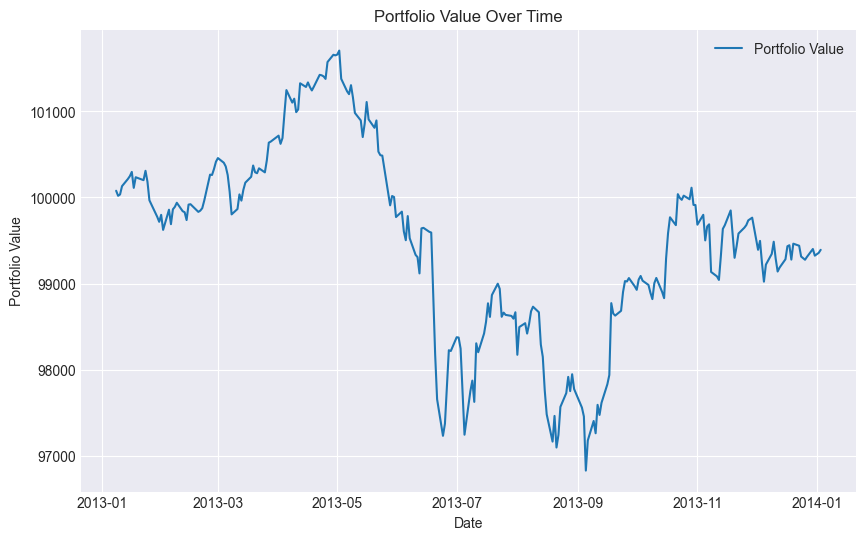

Asset Volatilities: Ticker
AGG     0.031522
DBC     0.180390
VIXY    0.598318
VTI     0.123899
Name: 2015-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     3.172434
DBC     0.554356
VIXY    0.167135
VTI     0.807110
Name: 2015-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     8.396302e-01
DBC     0.000000e+00
VIXY    1.894352e-17
VTI     1.603698e-01
Name: 2015-01-05 00:00:00, dtype: float64


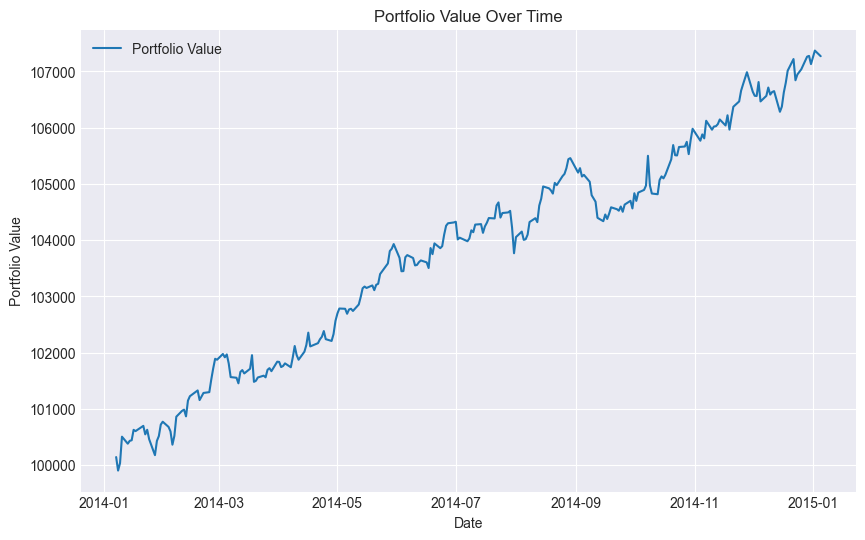

Asset Volatilities: Ticker
AGG     0.033328
DBC     0.162906
VIXY    0.791034
VTI     0.151150
Name: 2016-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     3.000504
DBC     0.613851
VIXY    0.126417
VTI     0.661594
Name: 2016-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.801383
DBC     0.000000
VIXY    0.004157
VTI     0.194460
Name: 2016-01-05 00:00:00, dtype: float64


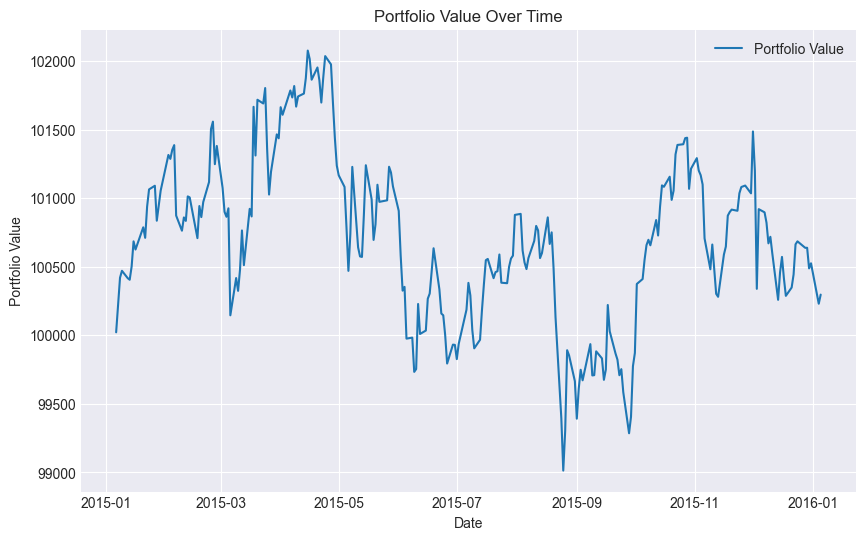

Asset Volatilities: Ticker
AGG     0.041372
DBC     0.162648
VIXY    0.501642
VTI     0.092567
Name: 2017-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     2.417081
DBC     0.614824
VIXY    0.199345
VTI     1.080303
Name: 2017-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.875672
DBC     0.000000
VIXY    0.002395
VTI     0.121933
Name: 2017-01-05 00:00:00, dtype: float64


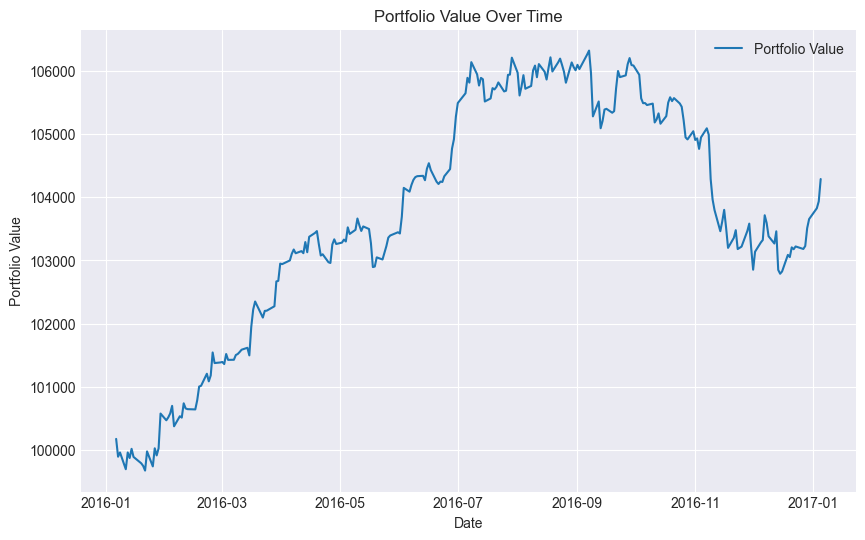

Asset Volatilities: Ticker
AGG     0.023325
DBC     0.108507
VIXY    0.308044
VTI     0.064037
Name: 2018-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     4.287187
DBC     0.921599
VIXY    0.324629
VTI     1.561609
Name: 2018-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     8.919585e-01
DBC     1.317988e-14
VIXY    0.000000e+00
VTI     1.080415e-01
Name: 2018-01-05 00:00:00, dtype: float64


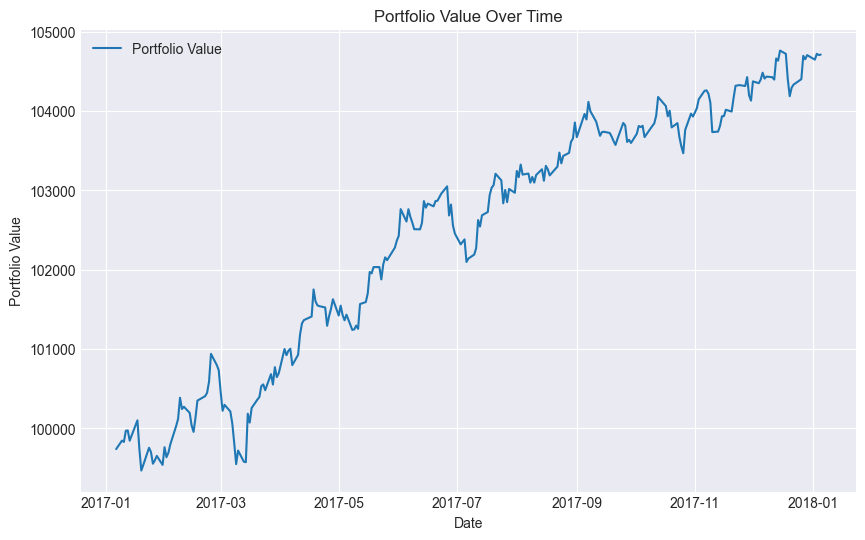

Asset Volatilities: Ticker
AGG     0.024476
DBC     0.185355
VIXY    0.714141
VTI     0.258217
Name: 2019-01-04 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     4.085575
DBC     0.539506
VIXY    0.140028
VTI     0.387271
Name: 2019-01-04 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.960404
DBC     0.005945
VIXY    0.000000
VTI     0.033651
Name: 2019-01-04 00:00:00, dtype: float64


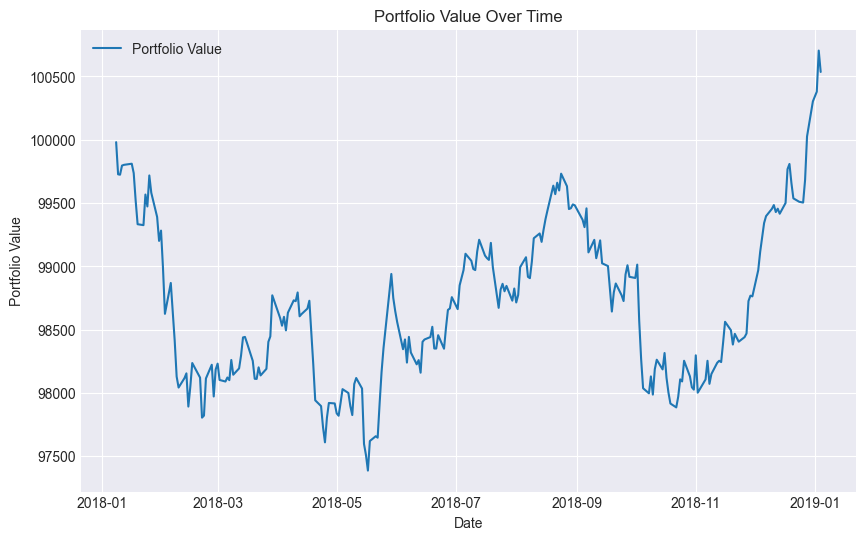

Asset Volatilities: Ticker
AGG     0.032830
DBC     0.112749
VIXY    0.434699
VTI     0.068737
Name: 2020-01-03 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     3.045958
DBC     0.886923
VIXY    0.230044
VTI     1.454810
Name: 2020-01-03 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.877664
DBC     0.000000
VIXY    0.001844
VTI     0.120492
Name: 2020-01-03 00:00:00, dtype: float64


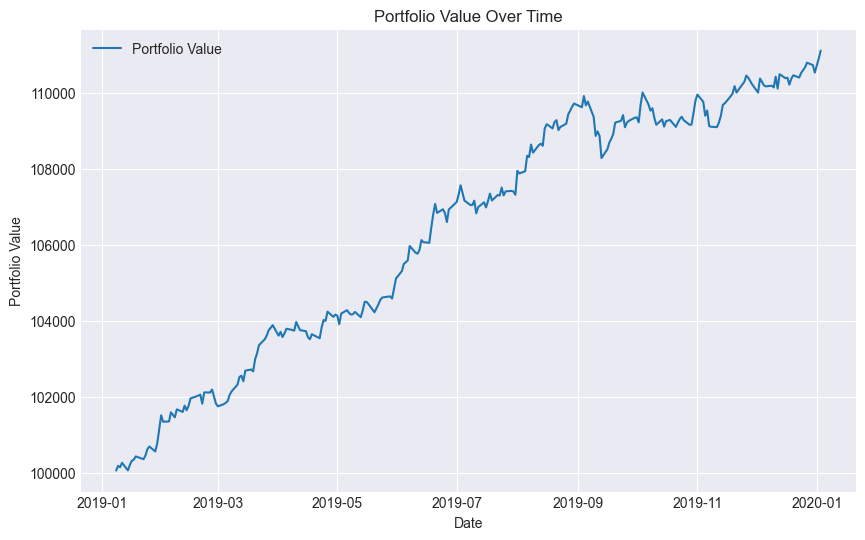

Mean-Variance Optimization Results: [{'train_period': (Timestamp('2011-01-04 00:00:00'), Timestamp('2013-01-04 00:00:00')), 'test_period': (Timestamp('2013-01-05 00:00:00'), Timestamp('2014-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': -0.18178565421783296, 'Sortino Ratio': -0.23596999910123076, 'Max Drawdown': 0.047924057777347574}}, {'train_period': (Timestamp('2012-01-04 00:00:00'), Timestamp('2014-01-04 00:00:00')), 'test_period': (Timestamp('2014-01-05 00:00:00'), Timestamp('2015-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': 2.8305732065473306, 'Sortino Ratio': 4.040210001308156, 'Max Drawdown': 0.010629356449883815}}, {'train_period': (Timestamp('2013-01-04 00:00:00'), Timestamp('2015-01-04 00:00:00')), 'test_period': (Timestamp('2015-01-05 00:00:00'), Timestamp('2016-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': 0.09568854730655056, 'Sortino Ratio': 0.1372328844760464, 'Max Drawdown': 0.030003945850459634}}, {'train_period': (Timestamp('2014-01-04 00:00:00'), Timestamp('2016-

In [13]:
# Define tickers and data parameters
tickers = ['VTI', 'AGG', 'DBC', 'VIXY']
data = get_data(tickers, '2006-04-01', '2020-04-01')

# Rolling validation with LSTM-based optimization (with periodic rebalancing)
lstm_results = generalized_rolling_validation(data, train_and_rebalance_portfolio)
print("LSTM Results:", lstm_results)

# Rolling validation with equal-weighted strategy
equal_weight_results = generalized_rolling_validation(data, equal_weighted_strategy)
print("Equal-Weighted Results:", equal_weight_results)

# Rolling validation with mean-variance optimization
mvo_results = generalized_rolling_validation(data, mean_variance_optimized_strategy)
print("Mean-Variance Optimization Results:", mvo_results)
